In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import hybdrt.plotting as hplt
from hybdrt.models import DRT, DiscreteElementModel

import fig_funcs as ff

%load_ext autoreload
%autoreload 2


In [2]:
# Set plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()

data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)

array([<AxesSubplot:xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>,
       <AxesSubplot:xlabel='$f$ (Hz)', ylabel='$|Z|$ ($\\Omega$)'>,
       <AxesSubplot:xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

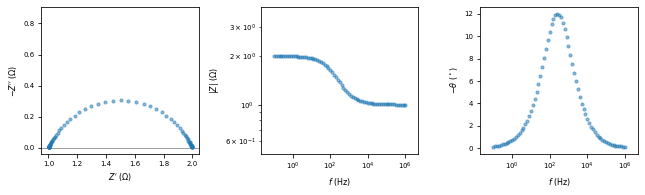

In [3]:
# Make ZARC model for nullspace demo
freq = np.logspace(6, -1, 71)
dem = DiscreteElementModel('R0-RQ1')
dem.parameter_values = np.array([
    1,
    1.0, np.log(1e-3), 0.7,
    # 1.0, np.log(1e-2), 0.7,
])

z_true = dem.predict_z(freq)

rng = np.random.default_rng(1489)
sigma = 0.0005
z_noise = rng.normal(0, sigma, len(z_true)) + 1j * rng.normal(0, sigma, len(z_true))
z_noisy = z_true + z_noise

# Plot simulated data
hplt.plot_eis((freq, z_noisy))

In [4]:
drt = DRT()

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


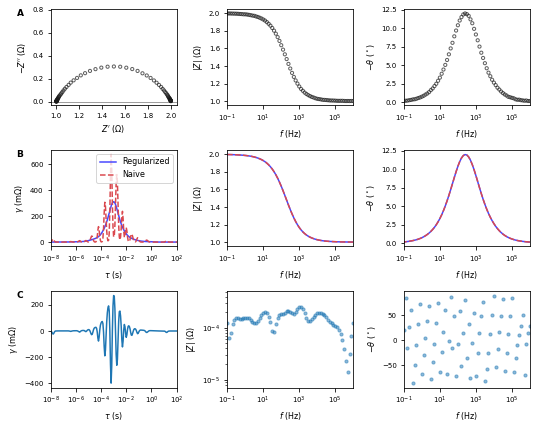

In [5]:
# Show how the nullspace of the conventional DRT affects inversion
fig, axes = plt.subplots(3, 3, figsize=(7.5, 6), sharex=False)

axes[0, 1].get_shared_x_axes().join(*axes[:, 1:].ravel())

# Plot data
hplt.plot_eis((freq, z_noisy), axes=axes[0], **data_kw, alpha=0.7, bode_kw=dict(log_mod=False))
    
# Regularized fit
drt.fit_eis(freq, z_noisy, l2_lambda_0=0)

# Unpenalized (naive) fit
drt_up = drt.copy()
drt.fit_eis(freq, z_noisy)

# Plot each fit
fits = [drt, drt_up]
ls = ['-', '--']
ms = ['', '']
for i, (fit, label) in enumerate(zip(fits, ['Regularized', 'Naive'])):
    fit.plot_distribution(ax=axes[1, 0], label=label, ls=ls[i], 
                          c=light_colors[i], marker=ms[i])
    fit.plot_eis_fit(axes=axes[1, 1:], plot_data=False, plot_type='bode', 
                     c=light_colors[i], marker=ms[i], ls=ls[i],
                     label=label, 
                     bode_cols=['Zmod', 'Zphz'], bode_kw=dict(log_mod=False))
    
axes[1, 0].legend()

    
# Plot diff
x = drt.qphb_history[-1]['x']
x_up = drt_up.qphb_history[-1]['x']


# fig, axes = plt.subplots(1, 3, figsize=(8, 3))
# ax = drt.plot_distribution(x=drt.qphb_history[-1]['x'])
# drt.plot_distribution(x=drt_up.qphb_history[-1]['x'], ax=ax)
drt.plot_distribution(x=x - x_up, ax=axes[2, 0])

z_diff = drt.predict_z(freq, x=x - x_up)
hplt.plot_bode((freq, z_diff), axes=axes[2, 1:], scale_prefix='')

for ax in axes [0, 1:]:
    ax.set_xlim(1e-1, 1e6)
    
for ax in axes[1:, 0]:
    ax.set_xlim(1e-8, 1e2)
    
ff.add_letters(axes[:, 0], loc=(-0.27, 1.))
    
# axes[1, 0].set_yscale
# ff.savefig(fig, 'Nullspace_RQ_example')

array([<AxesSubplot:xlabel='$f$ (Hz)', ylabel='$|Z|$ ($\\Omega$)'>,
       <AxesSubplot:xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

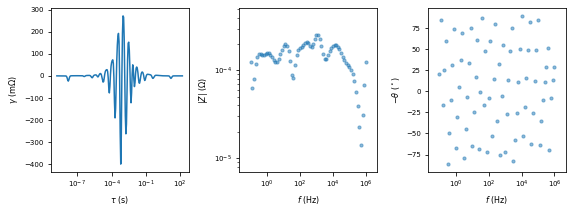

In [6]:
# Show that the difference between naive and regularized DRT estimates
# belongs to the null space
x = drt.qphb_history[-1]['x']
x_up = drt_up.qphb_history[-1]['x']

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
# ax = drt.plot_distribution(x=drt.qphb_history[-1]['x'])
# drt.plot_distribution(x=drt_up.qphb_history[-1]['x'], ax=ax)
drt.plot_distribution(x=x - x_up, ax=axes[0])

z_diff = drt.predict_z(freq, x=x - x_up)
hplt.plot_bode((freq, z_diff), axes=axes[1:], scale_prefix='')
# axes[1].set_xlim(-1000, 1000)
# axes[0].set_xlim(-1000, 1000)
# hplt.set_nyquist_aspect(axes[1], 'x', center_coords=(0, 0))

In [7]:
# DRT: extended basis to capture long-timescale peaks
drt_cpe = DRT(fixed_basis_tau=np.logspace(-8, 5, 131))

# DOP: limit DRT range and use delta function to get close to exact representation
dop_cpe = DRT(fixed_basis_tau=np.logspace(-8, -5, 31), fit_dop=True, nu_basis_type='delta',
              fixed_basis_nu=np.array([-0.5, -0.1])
            #   fixed_basis_nu=np.arange(-0.45, -0.551, -0.01)
              )

drt_fits = []
dop_fits = []
f_mins = [100, 1, 0.01]
for f_min in f_mins:
    print(f_min)
    lf = np.log10(f_min)
    f_cpe = np.logspace(6, lf, int(10 * (6 - lf) + 1))
    z_cpe = (1j * f_cpe * 2 * np.pi) ** -0.5

    # DRT: unregularized fit to capture all peaks
    drt_cpe.fit_eis(f_cpe, z_cpe, l2_lambda_0=1e-6)
    
    
    dop_cpe.fit_eis(f_cpe, z_cpe) #, dop_l2_lambda_0=10, dop_l1_lambda_0=1e6)
    # drt_cpe.plot_results(distribution_kw={'plot_ci': False})
    
    drt_fits.append(drt_cpe.copy())
    dop_fits.append(dop_cpe.copy())


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
100
1


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


0.01


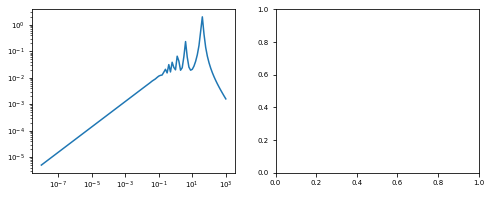

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

def g_w(tau, tau_0, n):
    q = (tau_0 / tau) ** n
    sinn = np.sin(n * np.pi)
    cosn = np.cos(n * np.pi)
    
    nume = (
        sinn * (1 - np.exp(-4 * q * cosn))
        -2 * cosn * np.exp(-2 * q * cosn) * np.sin(2 * q * sinn)
    )
    deno = (
        1 + 2 * np.exp(-2 * q * cosn) * np.cos(2 * q * sinn)
        + np.exp(-4 * q * cosn)
    )
    # return (1 / (3 * np.pi)) * (q ** 2) ** np.sin(2 * n * np.pi)
    return (np.pi * q) ** -1 * nume / deno

axes[0].plot(tau_plot, g_w(tau_plot, 100, 0.48))

axes[0].set_xscale('log')
axes[0].set_yscale('log')

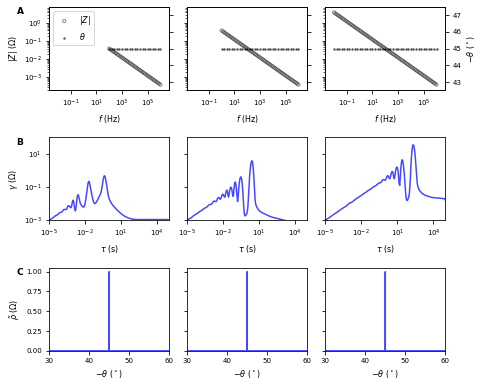

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(full_width, full_width * 0.8))

# f_mins = [100, 1, 0.01]

axes[0, 0].get_shared_x_axes().join(*axes[0])
axes[0, 0].get_shared_y_axes().join(*axes[0])

axes[1, 0].get_shared_x_axes().join(*axes[1])
axes[1, 0].get_shared_y_axes().join(*axes[1])

axes[2, 0].get_shared_x_axes().join(*axes[2])
axes[2, 0].get_shared_y_axes().join(*axes[2])

phase_axes = []
for i in range(len(f_mins)):
    lf = np.log10(f_mins[i])
    f_cpe = np.logspace(6, lf, int(10 * (6 - lf) + 1))
    z_cpe = (1j * f_cpe * 2 * np.pi) ** -0.5
    
    hplt.plot_bode((f_cpe, z_cpe), axes=axes[0, i], cols=['Zmod'], scale_prefix='', **data_kw,
                   label='$|Z|$')
    phase_ax = axes[0, i].twinx()
    phase_axes.append(phase_ax)
    hplt.plot_bode((f_cpe[::2], z_cpe[::2]), axes=phase_ax, cols=['Zphz'], marker='.', c='k',
                   label=r'$\theta$')
    
    drt_fits[i].plot_distribution(ax=axes[1, i], scale_prefix='', c=light_colors[0])
    
    nu_plot = np.unique(np.concatenate((np.linspace(0, -1, 30), [-0.5 - 1e-4, -0.5, -0.5 + 1e-4])))
    dop_fits[i].plot_dop(nu_plot,
                         ax=axes[2, i], scale_prefix='', normalize=True, normalize_tau=(1e0, 1e0),
                         c=light_colors[0])
    
h1, l1 = axes[0, 0].get_legend_handles_labels()
h2, l2 = phase_axes[0].get_legend_handles_labels()
axes[0, 0].legend(handles=h1 + h2, labels=l1 + l2, loc='upper left')
    
for ax in axes[0, 1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in phase_axes[:-1]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[1]:
    ax.set_yscale('log')
    ax.set_xlim(1e-5, 1e5)
    ax.set_ylim(1e-3, 1e2)
for ax in axes[1, 1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[2]:
    ax.set_xlim(30, 60)
    ax.set_ylim(0, 1.05)
for ax in axes[2, 1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
# dop_fits[0].plot_results()
# dop_fits[2].plot_results()

fig.tight_layout()
ff.add_letters(axes[:, 0], loc=(-0.27, 1.))

ff.savefig(fig, 'Supp_Nullspace_Warburg_DRT_vs_DOP')

## Gerischer

In [ ]:
dd_cpe = DRT(fixed_basis_tau=None, fit_dop=True, 
            #  nu_basis_type='delta',
            #   fixed_basis_nu=np.array([-0.5, -0.1])
              )

drt_cpe = DRT()


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


1
0.1


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


0.01


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


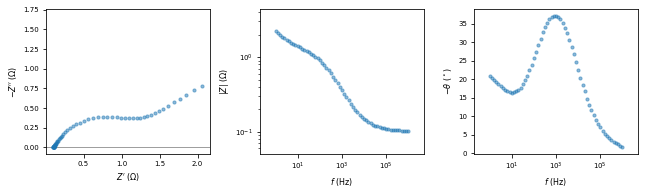

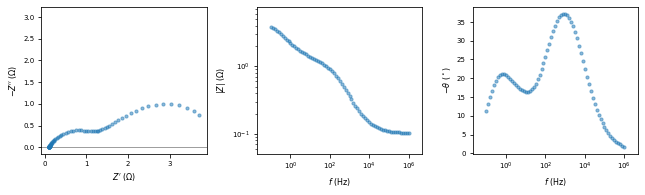

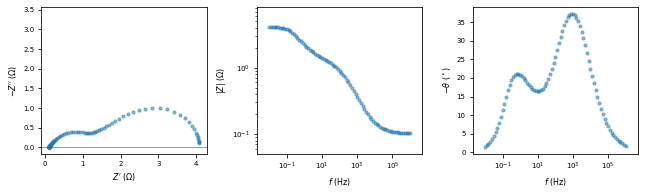

In [10]:

rng = np.random.default_rng(9329)

dem3 = DiscreteElementModel('R0-RQ1-HN2')
dem3.parameter_values = np.array([
    0.1,
    1.0, np.log(1e-3), 0.7,
    3.0, np.log(1e0), 0.5, 0.95
])

dd_ger_fits = []
drt_ger_fits = []
f_mins = [1, 0.1, 0.01]
# Generate single noise vector for consistency
sigma = 1e-4
n_max = int(10 * (6 - np.log10(f_mins[-1])) + 1)
zn = rng.normal(0, sigma, n_max) + 1j * rng.normal(0, sigma, n_max)
for f_min in f_mins:
    print(f_min)
    lf = np.log10(f_min)
    f_ger = np.logspace(6, lf, int(10 * (6 - lf) + 1))
    
    z_ger = dem3.predict_z(f_ger)
    # z_cpe = dem2.predict_z(f_cpe)
    # z_cpe = 0.1 + z_cpe + 1.0 / (1 + (1j * f_cpe * 2 * np.pi * 1e-3) ** 0.7)
    # z_cpe += 0.5 / (1 + (1j * f_cpe * 2 * np.pi * 1e-2) ** 0.7)
    # z_cpe = z_cpe + dem.predict_z(f_cpe)
    # sigma = np.max(np.abs(z_cpe )) * 0.001
    # z_cpe += rng.normal(0, sigma, len(f_cpe)) + 1j * rng.normal(0, sigma, len(f_cpe))
    z_ger += zn[:len(f_ger)]
    
    # hplt.plot_eis((f_ger, z_ger))

    dd_cpe.fit_eis(f_ger, z_ger, dop_l2_lambda_0=1)
    
    # drt_cpe.fit_eis(f_ger, z_ger)
    
    dd_ger_fits.append(dd_cpe.copy())
    # drt_ger_fits.append(drt_cpe.copy())

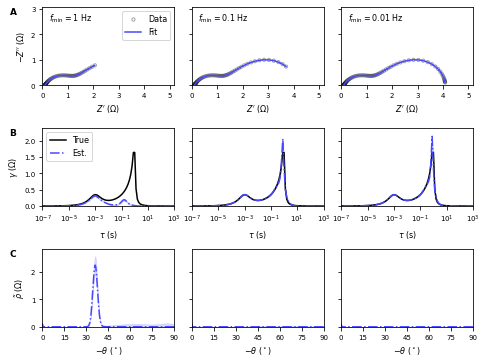

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(full_width, full_width * 0.75))

axes[0, 0].get_shared_x_axes().join(*axes[0])
axes[0, 0].get_shared_y_axes().join(*axes[0])

axes[1, 0].get_shared_x_axes().join(*axes[1])
axes[1, 0].get_shared_y_axes().join(*axes[1])

axes[2, 0].get_shared_x_axes().join(*axes[2])
axes[2, 0].get_shared_y_axes().join(*axes[2])

tau_plot = np.logspace(-8, 3, 111)

for i, fit in enumerate(dd_ger_fits):
    fit.plot_eis_fit(axes=axes[0, i], plot_type='nyquist', data_kw=data_kw | {'alpha': 0.4}, 
                     c=light_colors[0], label='Fit', data_label='Data')
    
    axes[0, i].text(0.05, 0.95, '$f_{{\mathrm{{min}}}}={:3g}$ Hz'.format(f_mins[i]), 
                    transform=axes[0, i].transAxes, ha='left', va='top')
    
    # z_max = abs((1j * f_mins[i] * 2 * np.pi) ** -0.5)
    
    dem3.plot_distribution(tau_plot, ax=axes[1, i], c='k', scale_prefix='', label='True')
    fit.plot_distribution(ax=axes[1, i], plot_ci=True, scale_prefix='', tau=tau_plot,
                          normalize=False, c=light_colors[0], label='Est.', ls='-.'
                        #   normalize_by=z_max
                          )
    
    # gamma = fit.predict_distribution(tau_plot)
    # axes[0, i].plot(tau_plot, 100 * gamma / z_max)
    # axes[0, i].set_xscale('log')
    
    # axes[2, i].axvline(45, c='k', ls='-', lw=1., label='True')
    fit.plot_dop(ax=axes[2, i], normalize=True, normalize_tau=(1e0, 1e0), scale_prefix='',
                 plot_ci=True, c=light_colors[0], label='Est.', ls='-.')
    
    
# axes[1, 0].set_ylabel('$\gamma \, / \, \mathrm{max}(|Z|)$ (%)')

for ax in axes[:, 1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[0, 1:]:
    ax.get_legend().remove()
    
for ax in axes[1]:
    ax.set_xlim(1e-7, 1e3)
    ff.zero_axlim(ax,'y')
    # ax.set_ylim(0, 0.35)
    
axes[1, 0].legend()
    
for ax in axes[2]:
    ax.set_xlim(0, 90)
    ax.set_xticks(np.arange(0., 90.1, 15))
    ff.zero_axlim(ax,'y')
    
# axes[2, 0].legend()
    
fig.tight_layout()

for ax in axes[0]:
    ff.zero_axlim(ax, 'y')
    hplt.set_nyquist_aspect(ax, 'y')
    
ff.add_letters(axes[:, 0])

ff.savefig(fig, 'Supp_Nullspace_DRT-DOP_Gerischer')